In [9]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline

In [2]:
# json_size = 150000
# for _json in pd.read_json('./data/dataset.json', chunksize=json_size, lines=True):
#     reviews = _json
#     break

In [2]:
business = pd.read_json('./data/dataset.json')
# columns_to_stay = ['business_id','name','review stars']
# business = business[columns_to_stay]
business.head()

,name,business_id,text,review stars,business stars,cool
0,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,The pizza was okay. Not the best I've had. I p...,2,4.0,0
1,Leticia's Mexican Cocina,pomGBqfbxcqPv14c3XH-ZQ,I love this place! My fiance And I go here atl...,5,4.0,0
10,National Car Rental,yFumR3CWzpfvTH2FCthvVw,I have been an Emerald Club member for a numbe...,5,4.0,0
100,Other Mama,7wHLFohwCw8l6WS-feLjeg,I had an amazing time here. They were very bus...,5,4.5,1
1000,Noodle Pot,5Lcit9Zt6TF9bmKoFMhF0g,"Terrible service period, since we don't speak ...",1,4.0,0


In [3]:
# dataset = reviews.merge(business,how='left', on='business_id')
# dataset.rename({'stars_x':'review stars', 'stars_y':'business stars'},inplace=True, axis='columns')
# dataset_columns_to_stay = ['name','business_id','text','review stars','business stars','cool']
# dataset = dataset[dataset_columns_to_stay]
# dataset.to_json('./data/dataset.json')
dataset = business
# dataset.head()

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [5]:
dataset['review stars'].shape

(150000,)

In [7]:
X = dataset['text'].tolist()
y = dataset['business stars'].tolist()


# X = tfidf.fit_transform(_text)

_pipe = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english',lowercase=True,analyzer='word',token_pattern=r'\w+')),
    ('linear', LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y)

_pipe.fit(X_train, y_train)
predict_linear = _pipe.predict(X_test)
print(mean_squared_error(y_test,predict_linear))

1.3069567787545098


In [8]:
_pipe_knr = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english',lowercase=True,analyzer='word',token_pattern=r'\w+')),
    ('KNR', KNeighborsRegressor(n_neighbors=5))
])
_pipe_knr.fit(X_train, y_train)
predict_knr = _pipe.predict(X_test)
print(mean_squared_error(y_test,predict_knr))

1.3069567787545098


In [6]:
len(dataset)

150000

In [8]:
len(dataset[dataset['text']==''])

0

In [24]:
texts1 = " ".join(text for text in dataset['text'][dataset['review stars'] == 1])
texts2 = " ".join(text for text in dataset['text'][dataset['review stars'] == 2])
texts3 = " ".join(text for text in dataset['text'][dataset['review stars'] == 3])
texts4 = " ".join(text for text in dataset['text'][dataset['review stars'] == 4])
texts5 = " ".join(text for text in dataset['text'][dataset['review stars'] == 5])

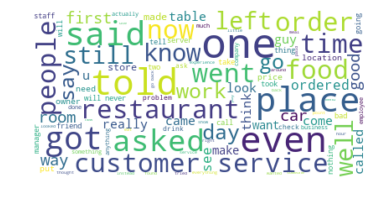

In [25]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(texts1)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

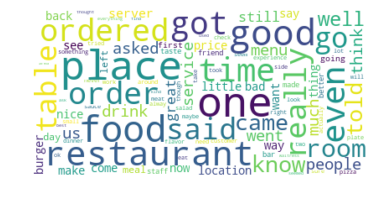

In [26]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(texts2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

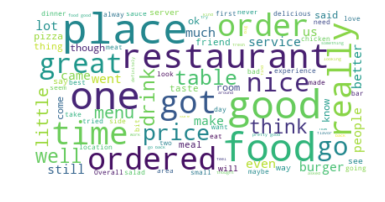

In [27]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(texts3)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

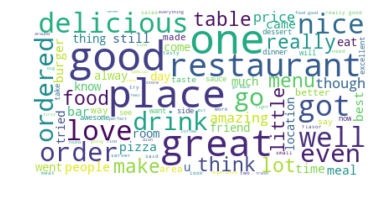

In [28]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(texts4)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

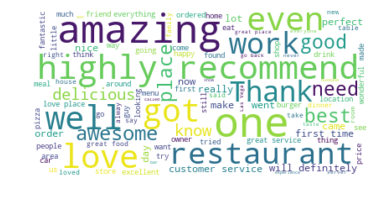

In [29]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(texts5)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()